# Creating the starting inventory and identifying the TSCA substances for degradation

- Created by: Grace Patlewicz
- Last date modified: 30 April 2024
- Merging OPERA predictions and inventory with PFAS Atlas assignments. Identifying TSCA substances for which degradation products need to be identified

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform


In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

Import new starting inventory prepared by AW and reviewed by TB et al

In [5]:
df = pd.read_excel(raw_dir+'DSSTox_PFAS8a7v3_20240426.xlsx')

/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
df = df[[ 'DSSTox_Substance_Id','DSSTox_QC-Level', 'Substance_Name',
       'Substance_CASRN', 'Substance_Type', 'Substance_Note',
       'Structure_SMILES', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt', 'Structure_SMILES_2D-QSAR']]

In [10]:
df.shape

(13054, 12)

In [11]:
df.rename(columns = {'DSSTox_Substance_Id' : 'dtxsid',  'Structure_SMILES':'smiles'}, inplace = True)

/tmp/ipykernel_741177/4233088707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'DSSTox_Substance_Id' : 'dtxsid',  'Structure_SMILES':'smiles'}, inplace = True)


There are 13,054 substances on this inventory represemted by 13,042 unique SMILES.

In [14]:
df.smiles.nunique()

13042

Pulling in the TSCA chemicals downloaded from public Dashboard 30 April 2024

In [18]:
tsca_active = pd.read_excel(raw_dir+'Chemical List TSCA_ACTIVE_NCTI_0224-2024-04-30.xlsx')

In [19]:
tsca_inactive = pd.read_excel(raw_dir+'Chemical List TSCA_INACTIVE_NCTI_0224-2024-04-30.xlsx')

In [22]:
inactive_dtx = tsca_inactive['DTXSID'].tolist()

In [23]:
active_dtx = tsca_active['DTXSID'].tolist()

In [29]:
len(inactive_dtx)

34387

In [31]:
#df['dtxsid']

In [34]:
df['TSCA_STATUS'] = df['dtxsid'].apply(lambda x: 'active' if x in active_dtx else ('inactive' if x in inactive_dtx else np.nan))

/tmp/ipykernel_741177/3662081939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TSCA_STATUS'] = df['dtxsid'].apply(lambda x: 'active' if x in active_dtx else ('inactive' if x in inactive_dtx else np.nan))


In [36]:
df['TSCA_STATUS'].value_counts()

inactive    326
active      237
Name: TSCA_STATUS, dtype: int64

There are 326 inactives and 237 actives on the TSCA inventory that are PFAS.

Pulling in the OPERA predictions and the PFAS Atlas assignments

In [37]:
opera = pd.read_csv(raw_dir+'DSSTox_PFAS8a7v3_20240426_V2000-sdf_OPERA2.9Pred.csv')

In [39]:
opera.columns

Index(['MoleculeID', 'MolWeight', 'nbAtoms', 'nbHeavyAtoms', 'nbC', 'nbO',
       'nbN', 'nbAromAtom', 'nbRing', 'nbHeteroRing',
       ...
       'Conf_index_CoMPARA_Bind', 'CATMoS_VT_pred', 'CATMoS_NT_pred',
       'CATMoS_EPA_pred', 'CATMoS_GHS_pred', 'CATMoS_LD50_pred',
       'CATMoS_LD50_predRange', 'AD_CATMoS', 'AD_index_CATMoS',
       'Conf_index_CATMoS'],
      dtype='object', length=150)

In [40]:
opera.shape

(12781, 150)

In [41]:
opera.rename(columns = {'MoleculeID': 'dtxsid'}, inplace = True)

In [44]:
df1 = pd.merge(df, opera, on = 'dtxsid', how = 'left')

In [51]:
atlas = pd.read_csv(external_dir+'new_inv_pfas_atlas_300424.csv', index_col=[0])

In [54]:
atlas = atlas[['Canonical_QSARr', 'Molecule name','First_Class', 'Second_Class' ]]

In [56]:
atlas.rename(columns = {'Canonical_QSARr': 'QSAR_READY_SMILES', 'Molecule name': 'dtxsid'}, inplace = True)

/tmp/ipykernel_741177/1210519823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atlas.rename(columns = {'Canonical_QSARr': 'QSAR_READY_SMILES', 'Molecule name': 'dtxsid'}, inplace = True)


In [60]:
atlas = atlas[['dtxsid', 'First_Class', 'Second_Class','QSAR_READY_SMILES']]

In [62]:
df1 = pd.merge(df1, atlas, on = 'dtxsid', how = 'left')

In [69]:
df1[df1['TSCA_STATUS'].notnull()].to_csv(interim_dir+'april2024_tsca_pfas.csv')

In [71]:

pfas_dict = {k:Chem.MolFromSmiles(v) for k,v in zip(df1['dtxsid'], df1['smiles'])}

[08:00:47] Explicit valence for atom # 1 Ge, 5, is greater than permitted
[08:00:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:47] Explicit valence for atom # 7 P, 12, is greater than permitted
[08:00:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[08:00:48] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8
[08:00:48] SMILES Parse Error: syntax error while parsing: Failed
[08:00:48] SMILES Parse Error: Failed parsing SMILES 'Failed' for input: 'Failed'
[08:00:48] Explicit valence for atom # 14 C, 5, is greater than permitted


In [72]:
def chain_length(mol, ch=30):
    mysr = 'C(F)(F)'
    mylst = []
    for n in range(1, ch):
        a = mol.HasSubstructMatch(Chem.MolFromSmarts(''.join(mysr * n)))
        mylst.append(a)
    return mylst.index(False)

In [73]:
errors = []
mydict = {}
for k,v in pfas_dict.items():
    try:
        mydict[k] = chain_length(v)
    except Exception as error:
        errors.append(k)

In [74]:
len(mydict)

13040

In [75]:
errors

['DTXSID90760101',
 'DTXSID901353500',
 'DTXSID901353479',
 'DTXSID901353443',
 'DTXSID801353507',
 'DTXSID701353497',
 'DTXSID601353313',
 'DTXSID501353310',
 'DTXSID501020454',
 'DTXSID20153820',
 'DTXSID201353478',
 'DTXSID101353506',
 'DTXSID101138156',
 'DTXSID00897518']

In [76]:
ch_df = pd.DataFrame(list(mydict.items()), columns = ['dtxsid', 'chain_length'])

In [79]:
#df1.columns.tolist()

In [80]:
df2 = pd.merge(df1, ch_df, on = 'dtxsid', how = 'left')

In [82]:
df2

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,CATMoS_GHS_pred,CATMoS_LD50_pred,CATMoS_LD50_predRange,AD_CATMoS,AD_index_CATMoS,Conf_index_CATMoS,First_Class,Second_Class,QSAR_READY_SMILES,chain_length
0,DTXSID90998543,Public_Low,"1,1,2,2,3,4,4,5-Octafluorocyclopentane",773-17-1,Single Compound,NaN,FC1C(F)(F)C(F)C(F)(F)C1(F)F,"InChI=1/C5H2F8/c6-1-3(8,9)2(7)5(12,13)4(1,10)1...",WAECBMNQMWVHQC-UHFFFAOYNA-N,C5H2F8,...,5.0,2043.0,[1100-3600],1.0,0.565,0.624,"PFAA precursors, cyclic","HFCs, cyclic",FC1(F)C(F)C(F)(F)C(F)(F)C1F,2.0
1,DTXSID90996549,Public_Low,"N,N'-(3,3'-Dichloro[1,1'-biphenyl]-4,4'-diyl)b...",75042-09-0,Single Compound,NaN,OC(=NC1=C(Cl)C=C(C=C1)C1=CC(Cl)=C(C=C1)N=C(O)C...,InChI=1S/C20H8Cl2F14N2O2/c21-9-5-7(1-3-11(9)37...,FHOSHAMDKGFWFV-UHFFFAOYSA-N,C20H8Cl2F14N2O2,...,3.0,NaN,NaN,0.0,0.000,0.000,Other PFASs,Aromatic PFASs,OC(=NC1C=CC(=CC=1Cl)C1=CC(Cl)=C(C=C1)N=C(O)C(F...,3.0
2,DTXSID90991670,Public_Low,"2-Chloro-1,1,1,2,3,4,4,4-octafluorobutane",71342-62-6,Single Compound,NaN,FC(C(F)(F)F)C(F)(Cl)C(F)(F)F,"InChI=1/C4HClF8/c5-2(7,4(11,12)13)1(6)3(8,9)10...",DGROXNFZUHBKQR-UHFFFAOYNA-N,C4HClF8,...,3.0,NaN,NaN,0.0,0.000,0.000,Other PFASs,Polyfluoroalkanes,FC(C(F)(Cl)C(F)(F)F)C(F)(F)F,1.0
3,DTXSID90990360,Public_Low,"2-Amino-1-[3-(1,1,2,2-tetrafluoroethoxy)phenyl...",70126-68-0,Single Compound,NaN,Cl.CC(N)C(O)C1=CC(OC(F)(F)C(F)F)=CC=C1,InChI=1/C11H13F4NO2.ClH/c1-6(16)9(17)7-3-2-4-8...,HHIOSMCMEMEDKT-UHFFFAOYNA-N,C11H14ClF4NO2,...,3.0,NaN,NaN,0.0,0.000,0.000,Other PFASs,Aromatic PFASs,CC(N)C(O)C1C=CC=C(C=1)OC(F)(F)C(F)F,2.0
4,DTXSID90987417,Public_Low,"1,1,2,2,3,3-Hexafluoropropane",680-00-2,Single Compound,NaN,FC(F)C(F)(F)C(F)F,"InChI=1S/C3H2F6/c4-1(5)3(8,9)2(6)7/h1-2H\nAuxI...",ZXVZGGVDYOBILI-UHFFFAOYSA-N,C3H2F6,...,4.0,402.0,[230-710],1.0,0.381,0.397,PFAA precursors,HFCs,FC(F)(C(F)F)C(F)F,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13049,DTXSID001010222,DSSTox_High,"3,5-Dichloro-2-fluoro-4-(1,1,2,3,3,3-hexafluor...",121451-05-6,Mixture of Stereoisomers,NaN,NC1=C(F)C(Cl)=C(OC(F)(F)C(F)C(F)(F)F)C(Cl)=C1,InChI=1/C9H4Cl2F7NO/c10-2-1-3(19)5(12)4(11)6(2...,IESKMXZVWJJXPA-UHFFFAOYNA-N,C9H4Cl2F7NO,...,3.0,NaN,NaN,0.0,0.000,0.000,Other PFASs,Aromatic PFASs,NC1C=C(Cl)C(OC(F)(F)C(F)C(F)(F)F)=C(Cl)C=1F,1.0
13050,DTXSID001009916,DSSTox_Low,Sodium 8-chloroperfluoro-1-octanesulfonate,2481740-05-8,Single Compound,NaN,[Na+].[O-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C8HClF16O3S.Na/c9-7(22,23)5(18,19)3(1...",ONBUURRKTXNGCZ-UHFFFAOYSA-M,C8ClF16NaO3S,...,3.0,NaN,NaN,0.0,0.000,0.000,Other PFASs,others,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,8.0
13051,DTXSID001009316,DSSTox_Low,"N-(Carboxymethyl)-N,N-dimethyl-3-(1H,1H,2H,2H-...",NOCAS_1009316,Single Compound,NaN,C[N+](C)(CCCNS(=O)(=O)CCC(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C17H19F17N2O4S/c1-36(2,8-9(37)38)6-3-...",CHXIOPKBQQWFAO-UHFFFAOYSA-O,C17H20F17N2O4S,...,3.0,NaN,NaN,0.0,0.000,0.000,Polyfluoroalkyl acids,PolyFCA derivatives,C[N+](C)(CCCNS(=O)(=O)CCC(F)(F)C(F)(F)C(F)(F)C...,8.0
13052,DTXSID001003249,Public_High_CAS,"Prop-2-en-1-yl 3,3-dichloro-2,2,3-trifluoropro...",83275-34-7,Single Compound,NaN,FC(Cl)(Cl)C(F)(F)C(=O)OCC=C,"InChI=1S/C6H5Cl2F3O2/c1-2-3-13-4(12)5(9,10)6(7...",YDSNWHBOQDVWSF-UHFFFAOYSA-N,C6H5Cl2F3O2,...,3.0,NaN,NaN,0.0,0.000,0.000,Polyfluoroalkyl acids,PolyFCA derivatives,C=CCOC(=O)C(F)(F)C(F)(Cl)Cl,1.0


In [88]:
pfas_tsca5= pd.read_csv(processed_dir+'pfas_tsca_degs_wcats.csv', index_col = [0])

In [89]:
pfas_tsca5.head()

,dtxsid,ID,smiles,chain_length,First_Class,Second_Class,QSAR_READY_SMILES,MolWeight,nbAtoms,nbHeavyAtoms,...,Conf_index_CoMPARA_Bind,CATMoS_VT_pred,CATMoS_NT_pred,CATMoS_EPA_pred,CATMoS_GHS_pred,CATMoS_LD50_pred,CATMoS_LD50_predRange,AD_CATMoS,AD_index_CATMoS,Conf_index_CATMoS
0,AACZGCBUSNLCIK-UHFFFAOYSA-N,"['DTXSID60887450_m_58', 'DTXSID60887450_m_89',...",OC(=O)CC(=O)C(=CC(O)=O)OS(=O)(=O)C(F)(F)C(F)(F...,5,PFAAs,PFSA derivatives,OC(=O)C=C(OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(...,505.952949,36.0,31.0,...,0.519,0.0,1.0,4.0,5.0,8101.0,[4600-14000],1.0,0.260,0.445
1,AAIAEOPDGOKSRA-UHFFFAOYSA-N,"['DTXSID40883016_m_22', 'DTXSID40883016_m_28',...",CCCCP(O)(=O)(CCCC).[N-](C)S(=O)(=O)C(F)(F)C(F)...,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AALULFMCJUWILT-UHFFFAOYSA-N,"['DTXSID30880554_m_136', 'DTXSID4070378_m_150']",CCN(CO)S(=O)(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)...,6,Other PFASs,others,CCN(CO)S(=O)(=O)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)...,485.033031,41.0,29.0,...,0.540,0.0,0.0,2.0,3.0,244.0,[140-430],1.0,0.341,0.426
3,ABABGEQVESLYDZ-UHFFFAOYSA-N,['DTXSID00880607_m_71'],OC(=CCC(=O)C(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(...,4,PFAA precursors,PASF-based substances,OC(=O)C(=O)CCC(=O)C(=O)CNS(=O)(=O)C(F)(F)C(F)(...,468.987777,37.0,29.0,...,0.535,0.0,1.0,4.0,5.0,8387.0,[4700-15000],1.0,0.297,0.402
4,ABJSXXCPMHRSGJ-UHFFFAOYSA-N,['DTXSID90880136_m_6'],OC(F)(F)C(F)(F)C(F)(F)C(F)(F)[Si](Cl)(Cl)Cl,4,Other PFASs,Si PFASs,OC(F)(F)C(F)(F)C(F)(F)C(F)(F)[Si](Cl)(Cl)Cl,349.873450,18.0,17.0,...,0.534,0.0,0.0,3.0,4.0,1710.0,[960-3000],1.0,0.306,0.381


In [91]:
new_inv = pd.concat([df2, pfas_tsca5])

Starting inventory is 13054 substances + 2927 degradates originating from the TSCA inventory

In [98]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [102]:
deg_inchi = {}
errors = []
for k,v in zip(new_inv[new_inv['ID'].notnull()]['dtxsid'], new_inv[new_inv['ID'].notnull()]['smiles']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        deg_inchi[k] = X

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefined stereo

[11:36:06] WARNING: Omitted undefi

In [101]:
parent_inchi = {}
errors = []
for k,v in zip(new_inv[new_inv['ID'].isnull()]['dtxsid'], new_inv[new_inv['ID'].isnull()]['smiles']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        parent_inchi[k] = X

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Proton(s) added/removed

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Proton(s) added/removed; Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27] WARNING: Omitted undefined stereo

[11:35:27]

In [106]:


matches = []
for k,v in parent_inchi.items():
    for x,y in deg_inchi.items():
        if v == y:
            matches.append([k,x,y])

In [125]:
matching_parents = pd.DataFrame(matches)[0].tolist()

In [112]:
degs_to_remove = pd.DataFrame(matches)[1].tolist()

In [115]:
len(set(degs_to_remove))

369

There are 2927 unique degradates that originate from the TSCA list that don't include the TSCA parents but if we do a final cross-walk with the rest of the inventory - a few more matches prevail. There are 384 substances in the main inventory that happen to be metabolites of TSCA chemicals. These will be dropped from the inventory. Note that these 384 correspond to 369 unique degradation products.

In [116]:
new_inv1 = new_inv[~new_inv['dtxsid'].isin(degs_to_remove)]

In [118]:
new_inv1.shape

(15612, 167)

In [119]:
new_inv1['ID'].info()

<class 'pandas.core.series.Series'>
Int64Index: 15612 entries, 0 to 3387
Series name: ID
Non-Null Count  Dtype 
--------------  ----- 
2558 non-null   object
dtypes: object(1)
memory usage: 243.9+ KB


In [120]:
15612-2558

13054

Final inventory comprises 15,612 substances of which 2558 correspond to degradation products of TSCA.

In [129]:
new_inv1

/tmp/ipykernel_741177/3280076843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_inv1.drop(['ID1'], axis = 1, inplace = True)


In [136]:
new_inv1['ID'] = new_inv1[['dtxsid', 'ID']].apply(lambda x: 'matches_tsca_degradate' if x['dtxsid'] in matching_parents else x['ID'], axis =1)

/tmp/ipykernel_741177/66769282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_inv1['ID'] = new_inv1[['dtxsid', 'ID']].apply(lambda x: 'matches_tsca_degradate' if x['dtxsid'] in matching_parents else x['ID'], axis =1)


In [138]:
new_inv1.drop(['ID1'], axis = 1, inplace = True)

/tmp/ipykernel_741177/3280076843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_inv1.drop(['ID1'], axis = 1, inplace = True)


In [135]:
12670+384

13054

In [139]:
new_inv1['ID'].info()

<class 'pandas.core.series.Series'>
Int64Index: 15612 entries, 0 to 3387
Series name: ID
Non-Null Count  Dtype 
--------------  ----- 
2942 non-null   object
dtypes: object(1)
memory usage: 243.9+ KB


In [145]:
new_inv1['Second_Class'].unique()

array(['HFCs, cyclic', 'Aromatic PFASs', 'Polyfluoroalkanes', 'HFCs',
       'Perfluoroalkanes, cyclic', 'PFAS derivatives', 'others',
       'Not PFAS by current definition', 'Amide derivatives', nan,
       'PolyFACs', 'HFEs', 'HFEs, cyclic', 'Si PFASs, cyclic', 'PAECFs',
       'PolyFCA derivatives', 'Si PFASs', 'PFECAs',
       'PolyFCA derivatives, cyclic', 'PFSIAs', 'PFCAs', 'PFALs',
       'PolyFCAs, cyclic', 'PolyFAC derivatives', 'PFPEs',
       'PFAK derivatives', 'Perfluoroalkylethers', 'others, cyclic',
       'PFACs', 'PolyFAenes',
       'n:2 fluorotelomer-based substances, cyclic',
       'PASF-based substances, cyclic', 'PFSA derivatives',
       'PolyFSA derivatives', 'PolyFEACs', 'SFAenes', 'PFAenes',
       'n:2 fluorotelomer-based substances', '(Hg,Sn,Ge,Sb,Se,B) PFASs',
       'PASF-based substances', 'PFSAs', 'PolyFCAs', 'PolyFSAs',
       'PFAK derivatives, cyclic', 'PFPIAs', 'PASFs, cyclic', 'PFPAs',
       'PolyFAenes, cyclic', 'Perfluoroalkanes', 'PFPEs, cycli

In [150]:
new_inv1['First_Class'] = new_inv1['First_Class'].replace(np.nan, 'unclassified')

/tmp/ipykernel_741177/1078083449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_inv1['First_Class'] = new_inv1['First_Class'].replace(np.nan, 'unclassified')


In [151]:
new_inv1['Second_Class'] = new_inv1['Second_Class'].replace(np.nan, 'unclassified')

/tmp/ipykernel_741177/4265824938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_inv1['Second_Class'] = new_inv1['Second_Class'].replace(np.nan, 'unclassified')


In [158]:
atlas_dict_enhanced = {
    'PFAAs': 
    ['PFPA', 'PFECA', 'PFdiCA', 'PFSIA', 'PFCA', 'PFCA-anhydrides', 'PFCA-ester derivatives', 'PFESA', 'PFPIA', 'PFdiSA', 'PFSA', 'PFSA derivatives'],
    'PFAA precursors': 
    ['HFO', 'PFAI', 'PACF', 'PAECF', 'PFAC', 'PolyFAC', 'PolyFEAC', 'PolyFAC derivatives', 'HFE', 'Polyfluoroalkanoyl acid chloride', 'Polyfluoroalkanoyl sulfonyl chloride', 'HFC', 'PFAL', 'PFAene', 'PolyFAene', 'perfluoroalkyl alcohols','PolyFEAene','perfluoroalkylether non-polymers', 'perfluoroalkene derivatives','PASF', 'PASF-based substances', 'PACF-based substances', 'PFAK', 'PFAK derivatives', 'SFA', 'SFAene', 'n1-FTOH', 'n1:FT','n2-FT'],
    'Polyfluoroalkyl acids':
    ['PolyFCA', 'PolyFCA derivatives', 'PolyFECA', 'PolyFSA', 'PolyFSA derivatives', 'PolyFESA'],
    'Other PFASs': 
    ['Perfluoroalkanes', 'Polyfluoroalkanes', 'PFPE','Silicon containing PFAS', 'Amide derivatives', 'Perfluoroalkylethers', 'Aromatic PFAS', 'Polyfluoroalkyl ethers and derivatives', 'Perfluoroalkyl-tert-amines', 'Hg Sn, Ge, Sb Se, B PFAS', 'PFAS derivatives', 'Others']
}

In [154]:
category_dict = {k: list(set(v['Second_Class'])) for k,v in new_inv1.groupby('First_Class')}
    

In [156]:
len(category_dict)

10

In [181]:
new_inv1['Second_Class'].nunique()

93

In [187]:
new_inv1['First_Class'].value_counts()

Other PFASs                      7245
PFAA precursors                  3643
Polyfluoroalkyl acids            1867
PFAAs                             863
Other PFASs, cyclic               730
PFAA precursors, cyclic           524
unclassified                      431
Polyfluoroalkyl acids, cyclic     199
PFAAs, cyclic                      75
Not PFAS                           35
Name: First_Class, dtype: int64

In [190]:
new_inv1.groupby(['First_Class', 'Second_Class']).size().reset_index().to_csv(external_dir+'april_inv_cats.csv')

In [186]:
new_inv1['Second_Class'].value_counts().reset_index()

,index,Second_Class
0,Aromatic PFASs,4014
1,others,1512
2,PASF-based substances,1467
3,PolyFCA derivatives,1409
4,Polyfluoroalkanes,465
...,...,...
88,"PFESAs, cyclic",2
89,"SFAenes, cyclic",1
90,"(Hg,Sn,Ge,Sb,Se,B) PFASs, cyclic",1
91,"HFOs, cyclic",1


In [198]:
cats_to_del=[]
for k, group in new_inv1.groupby(['First_Class', 'Second_Class']).size().reset_index().groupby('First_Class'):
    subset = group[['Second_Class', 0]]
    for idx, row in subset.iterrows():
        if row[0] >300:
            cats_to_del.append(row['Second_Class'])

In [221]:
category_dict_orig = category_dict.copy()

In [218]:
cats_to_del = cats_to_del[:-1]

In [222]:
removed_elements = {}

# Iterate over the dictionary values, remove elements, and store removed elements
for key, value in category_dict_orig.items():
    removed = [x for x in value if x in cats_to_del]
    if removed:
        removed_elements[key + '_misc'] = removed
    category_dict_orig[key] = [x for x in value if x not in cats_to_del]

# Merge the removed_elements dictionary into my_dict
category_dict_orig.update(removed_elements)


In [224]:
 {'Other PFASs_misc': ['Aromatic PFASs',
  'Polyfluoroalkanes',
  'others',
  'Si PFASs'],
 'Other PFASs, cyclic_misc': ['others, cyclic'],
 'PFAA precursors_misc': ['PASF-based substances',
  'n:2 fluorotelomer-based substances',
  'HFCs'],
 'Polyfluoroalkyl acids_misc': ['PolyFCA derivatives']}

{'Other PFASs_misc': ['Aromatic PFASs',
  'Polyfluoroalkanes',
  'others',
  'Si PFASs'],
 'Other PFASs, cyclic_misc': ['others, cyclic'],
 'PFAA precursors_misc': ['PASF-based substances',
  'n:2 fluorotelomer-based substances',
  'HFCs'],
 'Polyfluoroalkyl acids_misc': ['PolyFCA derivatives']}

In [233]:
new_inv1['Primary_Category'] = new_inv1[['First_Class', 'Second_Class']].apply(lambda x: x['Second_Class'] if x['Second_Class'] in cats_to_del else x['First_Class'], axis =1)

/tmp/ipykernel_741177/1439487590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_inv1['Primary_Category'] = new_inv1[['First_Class', 'Second_Class']].apply(lambda x: x['Second_Class'] if x['Second_Class'] in cats_to_del else x['First_Class'], axis =1)


<Axes: >

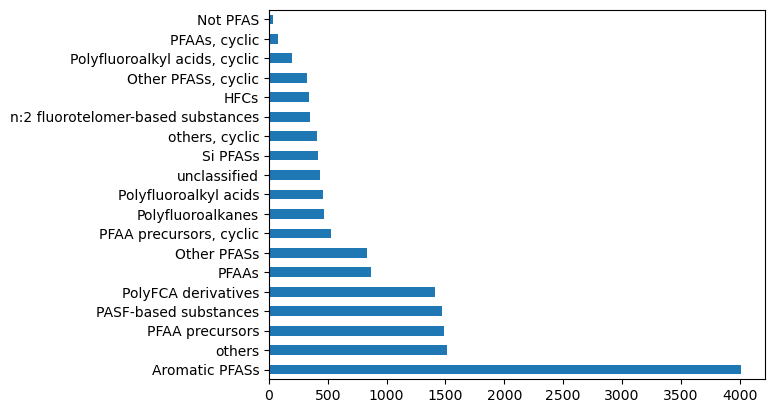

In [239]:
new_inv1.Primary_Category.value_counts().plot(kind = 'barh')

In [240]:
writer = pd.ExcelWriter(interim_dir+'universe_020524.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

new_inv1.to_excel(writer, sheet_name = 'universe')


writer.close()